In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

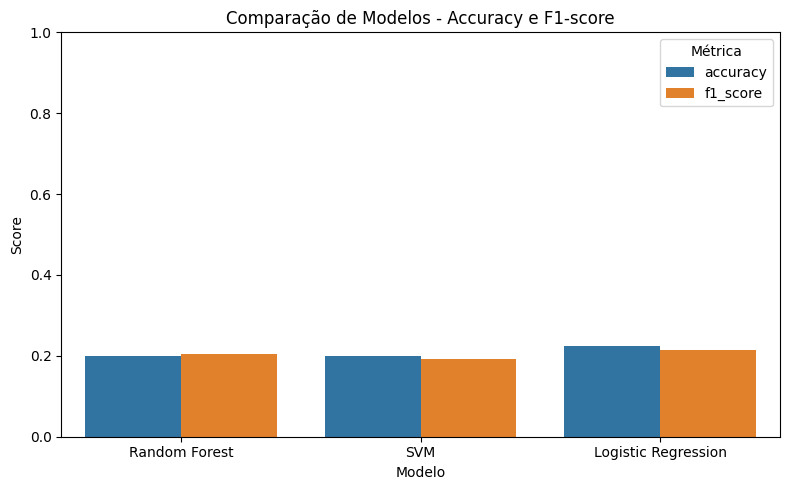

Tabela de resultados ordenada por F1-score:

                Modelo  accuracy  f1_score
2  Logistic Regression     0.225  0.213978
0        Random Forest     0.200  0.203456
1                  SVM     0.200  0.192626


In [3]:
# 1. Carregamento dos dados
df = pd.read_csv("fluxo_passageiros_200.csv")

# 2. Categorização da variável alvo
def categorizar_passageiros(valor):
    if valor <= 5000:
        return 'baixo'
    elif valor <= 10000:
        return 'médio'
    else:
        return 'alto'

df['Categoria'] = df['Passageiros'].apply(categorizar_passageiros)

# 3. Separação de variáveis
X = df.drop(columns=['Passageiros', 'Categoria'])
y = df['Categoria']

# 4. Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 5. Pré-processamento (OneHotEncoder para categóricas)
categorical_features = ['Estacao', 'Linha', 'Horario']
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# 6. Definição dos modelos
modelos = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

# 7. Treinamento, predição e avaliação
resultados = {}
melhor_f1 = 0
melhor_modelo = None

for nome, modelo in modelos.items():
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', modelo)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    resultados[nome] = {'accuracy': acc, 'f1_score': f1}

    if f1 > melhor_f1:
        melhor_f1 = f1
        melhor_modelo = pipeline

# 8. Gráfico comparativo
resultados_df = pd.DataFrame(resultados).T.reset_index().rename(columns={'index': 'Modelo'})

plt.figure(figsize=(8, 5))
sns.barplot(data=resultados_df.melt(id_vars='Modelo'), x='Modelo', y='value', hue='variable')
plt.title('Comparação de Modelos - Accuracy e F1-score')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(title='Métrica')
plt.tight_layout()
plt.show()

print("Tabela de resultados ordenada por F1-score:\n")
print(resultados_df.sort_values(by='f1_score', ascending=False))


In [4]:
# 9. Previsão com o melhor modelo
y_pred = melhor_modelo.predict(X_test)

resultado_final = X_test.copy()
resultado_final['Real'] = y_test.values
resultado_final['Previsto'] = y_pred

print("\nPrimeiras 10 previsões do conjunto de teste:\n\n")
print(resultado_final.head(10))


Primeiras 10 previsões do conjunto de teste:


          Estacao               Linha Horario   Real Previsto
2              Sé      Linha 1 - Azul   09:00   alto     alto
91    Barra Funda      Linha 1 - Azul   16:00  baixo    médio
77      República   Linha 4 - Amarela   22:00   alto     alto
153           Luz     Linha 5 - Lilás   07:00  baixo     alto
37   Vila Mariana     Linha 2 - Verde   13:00  médio    médio
183  Vila Mariana     Linha 2 - Verde   19:00  médio    médio
108           Luz  Linha 3 - Vermelha   08:00  médio     alto
159      Ana Rosa     Linha 2 - Verde   19:00  médio    médio
81        Paraíso     Linha 2 - Verde   13:00  médio    médio
140           Luz   Linha 4 - Amarela   06:00  médio     alto


<Figure size 600x500 with 0 Axes>

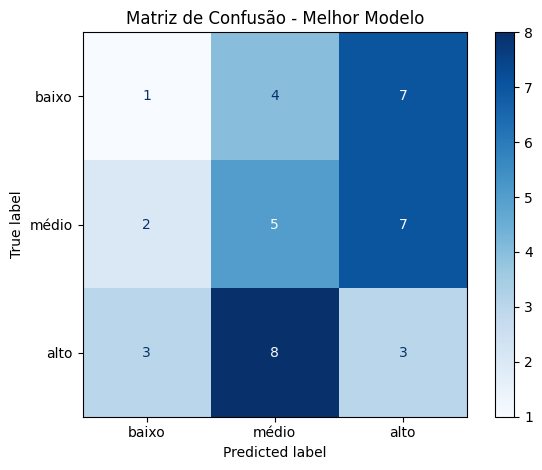

In [5]:
# 10. Matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=['baixo', 'médio', 'alto'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['baixo', 'médio', 'alto'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Melhor Modelo')
plt.tight_layout()
plt.show()

In [7]:
# 11. Salvar o melhor modelo
joblib.dump(melhor_modelo, 'melhor_modelo.pkl')
print("\n✅ Melhor modelo salvo como 'melhor_modelo.pkl'\n\n")


✅ Melhor modelo salvo como 'melhor_modelo.pkl'


